### Data

The sentiment analysis model within this notebook uses publicly available datasets:

1. Large Movie Review Dataset: https://ai.stanford.edu/~amaas/data/sentiment/
2. Sentiment Polarity Dataset (v1 and v2): https://www.cs.cornell.edu/people/pabo/movie-review-data/
3. Rotten Tomatoes web scraped critic reviews: https://www.kaggle.com/datasets/stefanoleone992/rotten-tomatoes-movies-and-critic-reviews-dataset/

All data is contained in the "data" directory (not committed in this repo).
The code below assumes the same directory structure as the original datasets under the root "data" folder.

In [1]:
import os
from dataset_utils import *

train_path = os.path.join(IMDB_DATA_PATH, "train")
test_path  = os.path.join(IMDB_DATA_PATH, "test")

#For details on implementation of dataset loading and other utils check out dataset_utils.py

#Main training set - Large Movie Review Dataset (IMDB)
((imdb_train_texts, imdb_train_labels), (imdb_test_texts, imdb_test_labels)) = load_imdb_dataset(train_path=train_path, test_path=test_path)

#Review Polarity Datasets
(v1_texts, v1_labels), (v2_texts, v2_labels) = load_polarity(v1_path=POLARITY_v1_DATA_PATH, v2_path=POLARITY_v2_DATA_PATH)

#Rotten tomatoes critic dataset
rotten_train_texts, rotten_train_labels, short_rotten_test, random_rotten_test = load_rotten_split(ROTTEN_PATH)

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def plot_len_dist(dataset_name, texts):
    data=[len(text) for text in texts]
    median = np.median(data)
    plt.hist(data, 50)
    plt.axvline(x=median, color='red', linestyle='dashed', linewidth=2, label='Mean')
    plt.text(median + 0.5, 50, f'Median: {median:.2f}', color='red', fontsize=10)
    plt.title(f"Length of sample over number of samples: {dataset_name}")
    plt.xlabel("Length of a sample")
    plt.ylabel("Number of samples")
    plt.show()
    
def plot_wordcount_dist(dataset_name, texts):
    data=[len(text.split(" ")) for text in texts]
    median=np.median(data)
    plt.hist(data, 50)
    plt.axvline(x=median, color='red', linestyle='dashed', linewidth=2, label='Mean')
    plt.text(median + 0.5, 50, f'Median: {median:.2f}', color='red', fontsize=10)
    plt.title(f"Number of words: {dataset_name}")
    plt.xlabel("Number of words in a sample")
    plt.ylabel("Number of samples")
    plt.show()

# for title, texts in [('IMDB_train', imdb_train_texts), ('IMDB_test', imdb_test_texts), ('polarity_v1', v1_texts), ('polarity_v2',v2_texts),
#                      ('rotten_train', rotten_train_texts), ('rotten_test', rotten_test_texts)]:
#     plot_len_dist(title, texts)
#     plot_wordcount_dist(title, texts)
    

In [3]:
for texts, labels, name in [(imdb_train_texts, imdb_train_labels, 'imdb_train'), (imdb_test_texts, imdb_test_labels, 'imdb_test'),
                            (v1_texts, v1_labels, 'polarity_v1'), (v2_texts, v2_labels, 'polarity_v2'),
                            (rotten_train_texts, rotten_train_labels, 'rotten tomatoes train')]:
    
    display_dataset_info(texts, labels, name)

Dataset: imdb_train.
Total number of samples: 25000
Positive reviews total: 12500
Negative reviews total: 12500
--------------------------------------
Dataset: imdb_test.
Total number of samples: 25000
Positive reviews total: 12500
Negative reviews total: 12500
--------------------------------------
Dataset: polarity_v1.
Total number of samples: 10662
Positive reviews total: 5331
Negative reviews total: 5331
--------------------------------------
Dataset: polarity_v2.
Total number of samples: 2000
Positive reviews total: 1000
Negative reviews total: 1000
--------------------------------------
Dataset: rotten tomatoes train.
Total number of samples: 50000
Positive reviews total: 25000
Negative reviews total: 25000
--------------------------------------


In [4]:
from sklearn.model_selection import train_test_split

train_texts_v1, test_texts_v1, train_labels_v1, test_labels_v1 = train_test_split(v1_texts, v1_labels, test_size=0.33, random_state=42)

train_texts = imdb_train_texts + rotten_train_texts + train_texts_v1
train_labels = imdb_train_labels + rotten_train_labels + train_labels_v1

In [5]:
short_test_v1 = [(test_labels_v1[index], text) for index, text in enumerate(test_texts_v1) if len(text.split(" ")) < 25]
short_test = short_test_v1 + short_rotten_test

long_test_v2 = [(v2_labels[index], text) for index, text in enumerate(v2_texts) if len(text.split(" ")) > 300]
long_test_imdb = [(imdb_test_labels[index], text) for index, text in enumerate(imdb_test_texts) if len(text.split(" ")) > 300]

long_test = long_test_v2 + long_test_imdb

In [29]:
random.shuffle(long_test)

In [31]:
seed=10

random.seed(seed)
random.shuffle(short_test)
random.shuffle(long_test)

In [7]:
import torch

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, f_classif


MAX_FEATURES = 5000

transformer_pipeline = Pipeline([
    ('vect', TfidfVectorizer(min_df=8, ngram_range=(1,2))),
    ('select', SelectKBest(k=MAX_FEATURES))
])

transformed_train = transformer_pipeline.fit_transform(train_texts, train_labels)

X_train = torch.from_numpy(transformed_train.toarray()).to(dtype=torch.float32)
y_train = torch.tensor(train_labels, dtype=torch.float32).unsqueeze(1)

vectorizer = transformer_pipeline.named_steps['vect']
selector   = transformer_pipeline.named_steps['select']

In [48]:
from torch import nn

input_dim = X_train.shape[1]

class SentimentCLF(nn.Module):
    def __init__(self, n_hidden, n_units, dropout_p):
        super().__init__()
        
        self.linear_stack = nn.Sequential(nn.Linear(input_dim, n_units), nn.ReLU())
        
        for _ in range(n_hidden):
            self.linear_stack.append(nn.Linear(n_units, n_units))
            self.linear_stack.append(nn.ReLU())
        
        self.linear_stack.append(nn.Linear(n_units, 1))
                    
        self.dropout = nn.Dropout(p=dropout_p)

    def forward(self, x):
        dropped = self.dropout(x)
        logits = self.linear_stack(dropped)
        
        return logits

In [49]:
from skorch import NeuralNetClassifier

net = NeuralNetClassifier(
    module=SentimentCLF,
    module__n_units=500,
    module__dropout_p=0.6,
    module__n_hidden=2,
    lr = 0.001,
    criterion=nn.BCEWithLogitsLoss,   
    device='cuda',
    max_epochs=15,
    optimizer=torch.optim.Adam,
    batch_size=64,
    iterator_train__shuffle=True
)

In [ ]:
from sklearn.model_selection import GridSearchCV

net.set_params(train_split=False, verbose=0)

param_grid = {
    'module__dropout_p': [0.6],
    'module__n_units': [100, 500, 1000],
    'module__n_hidden': [1, 2, 3],
    'lr': [0.0001]
}

gs = GridSearchCV(net, param_grid=param_grid, refit=False, cv=3, scoring='accuracy', verbose=3)
#gs.fit(X_train, y_train)
#print(gs.best_score_, gs.best_params_)

In [ ]:
#net.set_params(**gs.best_params_)

In [50]:
net.fit(X_train, y_train)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5565       0.8906        0.2790  4.8941
      2        0.5188       0.8970        0.2592  4.4626
      3        0.5070       0.8952        0.2590  4.3437
      4        0.4994       0.9035        0.2372  4.2503
      5        0.4955       0.9030        0.2461  4.3264
      6        0.4874       0.9044        0.2343  4.3235
      7        0.4834       0.9052        0.2342  4.1934
      8        0.4835       0.9003        0.2574  4.2194
      9        0.4756       0.8924        0.2529  4.4568
     10        0.4686       0.8900        0.2751  4.4385
     11        0.4658       0.8956        0.2434  4.4296
     12        0.4614       0.8988        0.2519  4.2558
     13        0.4559       0.8842        0.2595  4.1782
     14        0.4504       0.8841        0.2646  4.3034
     15        0.4444       0.8731        0.2883  4.4429


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=SentimentCLF(
    (linear_stack): Sequential(
      (0): Linear(in_features=5000, out_features=500, bias=True)
      (1): ReLU()
      (2): Linear(in_features=500, out_features=500, bias=True)
      (3): ReLU()
      (4): Linear(in_features=500, out_features=500, bias=True)
      (5): ReLU()
      (6): Linear(in_features=500, out_features=1, bias=True)
    )
    (dropout): Dropout(p=0.6, inplace=False)
  ),
)

# Testing

### Sets:
- IMDB: Small, medium, large
- Short reviews: Small, large
- Long reviews
- Rotten reviews, mixed (rotten are mostly short reviews)

In [44]:
#Splitting the imdb test reviews and their label into 3 datasets based on size:
#small-1000, medium-5000, large-19000
imdb_small_test_texts  = imdb_test_texts[:1000]
imdb_small_test_labels = imdb_test_labels[:1000]

imdb_medium_test_texts  = imdb_test_texts[1000:6000]
imdb_medium_test_labels = imdb_test_labels[1000:6000]

imdb_large_test_texts  = imdb_test_texts[6000:]
imdb_large_test_labels = imdb_test_labels[6000:]

#Splitting the short reviews dataset into 2 - sm and large 
short_test_sm = short_test[:3000]
short_test_lg = short_test[3000:]

short_test_sm_texts  = [text for _, text in short_test_sm]
short_test_sm_labels = [label for label, _ in short_test_sm]

short_test_lg_texts  = [text for _, text in short_test_lg]
short_test_lg_labels = [label for label, _ in short_test_lg]

In [45]:
X_imdb_sm_test = torch.from_numpy(transformer_pipeline.transform(imdb_small_test_texts).toarray()).to(dtype=torch.float32)
X_imdb_md_test = torch.from_numpy(transformer_pipeline.transform(imdb_medium_test_texts).toarray()).to(dtype=torch.float32)
X_imdb_lg_test = torch.from_numpy(transformer_pipeline.transform(imdb_large_test_texts).toarray()).to(dtype=torch.float32)

y_imdb_sm_test = torch.tensor(imdb_small_test_labels, dtype=torch.float32)
y_imdb_md_test = torch.tensor(imdb_medium_test_labels, dtype=torch.float32)
y_imdb_lg_test = torch.tensor(imdb_large_test_labels, dtype=torch.float32)

X_short_sm_test = torch.from_numpy(transformer_pipeline.transform(short_test_sm_texts).toarray()).to(dtype=torch.float32)
X_short_lg_test = torch.from_numpy(transformer_pipeline.transform(short_test_lg_texts).toarray()).to(dtype=torch.float32)

y_short_sm_test = torch.tensor(short_test_sm_labels, dtype=torch.float32)
y_short_lg_test = torch.tensor(short_test_lg_labels, dtype=torch.float32)

X_rotten_test = torch.from_numpy(transformer_pipeline.transform([text for _, text in random_rotten_test]).toarray()).to(dtype=torch.float32)
y_rotten_test = torch.tensor([label for label, _ in random_rotten_test], dtype=torch.float32)

X_long_test = torch.from_numpy(transformer_pipeline.transform([text for _, text in long_test]).toarray()).to(dtype=torch.float32)
y_long_test = torch.tensor([label for label, _ in long_test], dtype=torch.float32)

In [67]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

test_sets = [(X_imdb_sm_test, y_imdb_sm_test, 'imdb_sm'), (X_imdb_md_test, y_imdb_md_test, 'imdb_md'), (X_imdb_lg_test, y_imdb_lg_test, 'imdb_lg'),
             (X_short_sm_test, y_short_sm_test, 'short_sm'), (X_short_lg_test, y_short_lg_test, 'short_lg'),
             (X_rotten_test, y_rotten_test, 'rotten_mix'), (X_long_test, y_long_test, 'long')]


def test_loop(X, y, set_name, model):
    print(f"DATASET: {set_name}")
    
    pred = model.predict(X)
    
    acc = accuracy_score(pred, y)
    cm = confusion_matrix(y, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    
    print(f"Accuracy score: {acc}")
    
    disp.plot()
    plt.show()
    
    print('--------------------------------------')

DATASET: imdb_sm
Accuracy score: 0.856


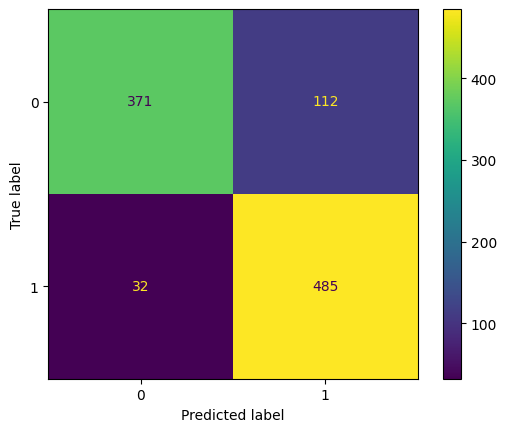

--------------------------------------
DATASET: imdb_md
Accuracy score: 0.8712


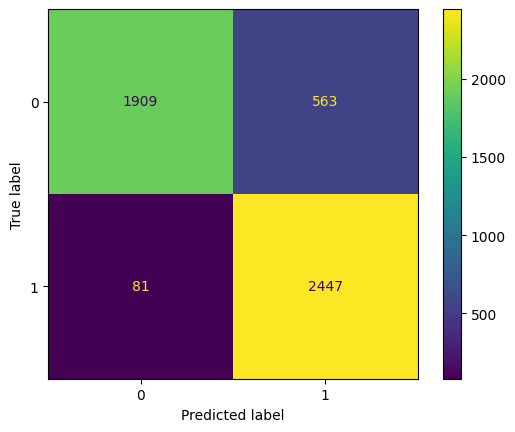

--------------------------------------
DATASET: imdb_lg
Accuracy score: 0.8609473684210527


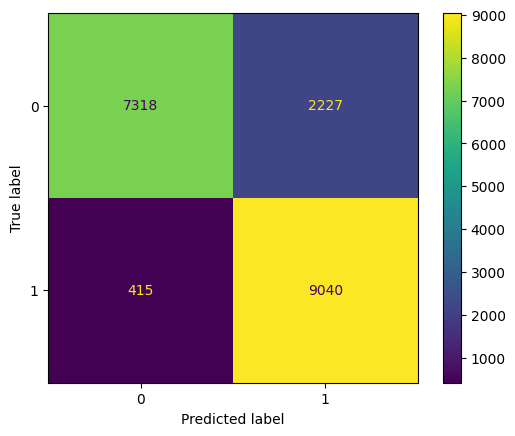

--------------------------------------
DATASET: short_sm
Accuracy score: 0.7733333333333333


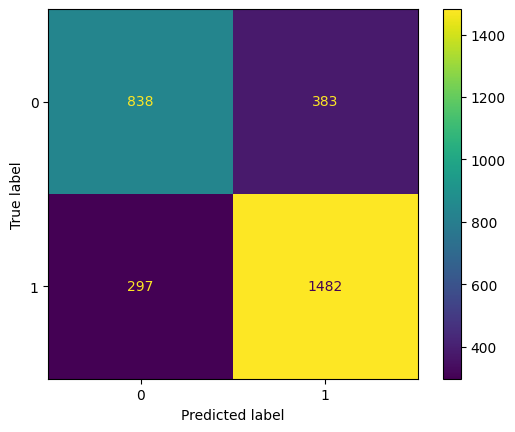

--------------------------------------
DATASET: short_lg
Accuracy score: 0.7849695916594266


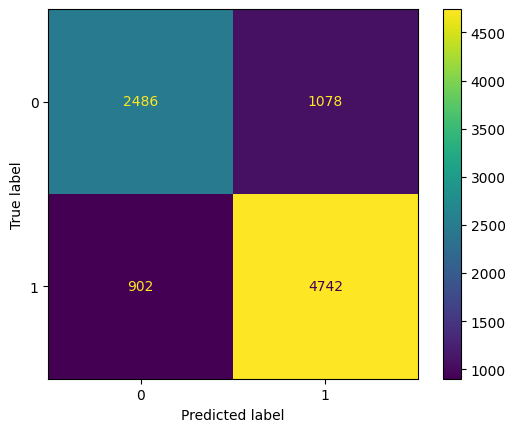

--------------------------------------
DATASET: rotten_mix
Accuracy score: 0.7851


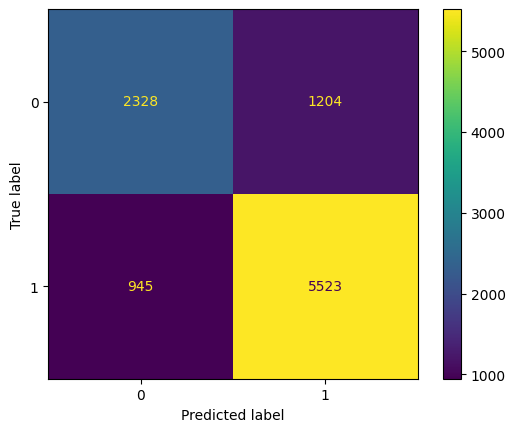

--------------------------------------
DATASET: long
Accuracy score: 0.8448734088683731


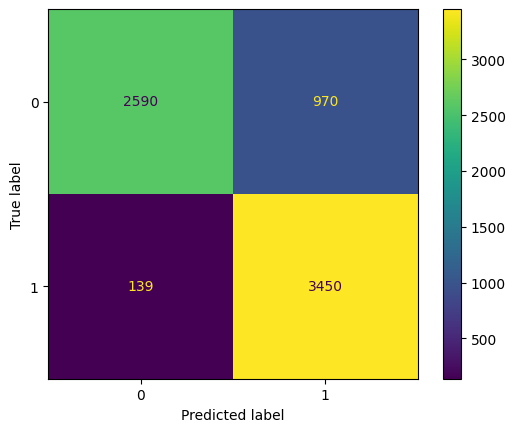

--------------------------------------


In [68]:
for (X_test, y_test, name) in test_sets:
    test_loop(X_test, y_test, set_name=name, model=net)